In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix
from category_encoders import WOEEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
sns.set_palette('pastel')

import warnings
warnings.simplefilter("ignore")

In [9]:
test_df = pd.read_csv('../data/cleaned_test.csv')
train_df = pd.read_csv('../data/cleaned_train.csv')

In [3]:
train_df.head()

,cc_num,trans_date_trans_time,category,amt,lat,long,merch_lat,merch_long,is_fraud
0,2703186189652095,2019-01-01 00:00:18,misc_net,4.97,36.0788,-81.1781,36.011293,-82.048315,0
1,630423337322,2019-01-01 00:00:44,grocery_pos,107.23,48.8878,-118.2105,49.159047,-118.186462,0
2,38859492057661,2019-01-01 00:00:51,entertainment,220.11,42.1808,-112.2620,43.150704,-112.154481,0
3,3534093764340240,2019-01-01 00:01:16,gas_transport,45.00,46.2306,-112.1138,47.034331,-112.561071,0
4,375534208663984,2019-01-01 00:03:06,misc_pos,41.96,38.4207,-79.4629,38.674999,-78.632459,0


In [10]:
def add_rolling_avg_features(df):
    # Ensure datetime format
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    # Sort data by cc_num and transaction time
    df = df.sort_values(by=['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

    # Store original index for restoring later
    original_index = df.index

    # Set datetime index temporarily
    df.set_index('trans_date_trans_time', inplace=True)

    # Group by card
    grouped = df.groupby('cc_num')

    # --- 1. Rolling features: time-based (last 1h and 24h) ---
    df['last_hour_sum'] = grouped['amt'].rolling('1h').sum().reset_index(level=0, drop=True)
    df['last_hour_count'] = grouped['amt'].rolling('1h').count().reset_index(level=0, drop=True)
    df['last_hour_avg'] = (df['last_hour_sum'] / df['last_hour_count']).round(2)

    df['last_24h_sum'] = grouped['amt'].rolling('24h').sum().reset_index(level=0, drop=True)
    df['last_24h_count'] = grouped['amt'].rolling('24h').count().reset_index(level=0, drop=True)
    df['last_24h_avg'] = (df['last_24h_sum'] / df['last_24h_count']).round(2)

    # --- 2. Rolling median of last 250 transactions (time-based, up to this row) ---
    # For each cc_num group, apply rolling window of 250 and compute median
    rolling_250_mean = (grouped['amt'].rolling(window=250, min_periods=1).mean().reset_index(level=0, drop=True))
    df['last_250_mean'] = rolling_250_mean

    # --- 3. Restore index ---
    df.reset_index(inplace=True)
    df.index = original_index

    # --- 4. Fill NaNs ---
    df['last_hour_avg'] = df['last_hour_avg'].fillna(0)
    df['last_24h_avg'] = df['last_24h_avg'].fillna(0)
    df['last_250_mean'] = df['last_250_mean'].fillna(0)

    return df

# Apply to both train and test
train = add_rolling_avg_features(train_df)
test = add_rolling_avg_features(test_df)

train.head()

,trans_date_trans_time,cc_num,category,amt,lat,long,merch_lat,merch_long,is_fraud,last_hour_sum,last_hour_count,last_hour_avg,last_24h_sum,last_24h_count,last_24h_avg,last_250_mean
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,43.0048,-108.8964,43.974711,-109.741904,0,7.27,1.0,7.27,7.27,1.0,7.27,7.270
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,43.0048,-108.8964,42.018766,-109.044172,0,52.94,1.0,52.94,60.21,2.0,30.10,30.105
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,43.0048,-108.8964,42.961335,-109.157564,0,135.02,2.0,67.51,142.29,3.0,47.43,47.430
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,43.0048,-108.8964,42.228227,-108.747683,0,34.79,1.0,34.79,177.08,4.0,44.27,44.270
4,2019-01-02 13:10:46,60416207185,home,27.18,43.0048,-108.8964,43.321745,-108.091143,0,61.97,2.0,30.98,196.99,4.0,49.25,40.852


In [66]:
train.head(30)

,trans_date_trans_time,cc_num,category,amt,lat,long,merch_lat,merch_long,unix_time,is_fraud,last_hour_count,last_hour_avg,last_24h_count,last_24h_avg
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,43.0048,-108.8964,43.974711,-109.741904,1325422035,0,1.0,7.27,1.0,7.27
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,43.0048,-108.8964,42.018766,-109.044172,1325493897,0,1.0,52.94,2.0,30.10
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,43.0048,-108.8964,42.961335,-109.157564,1325494056,0,2.0,67.51,3.0,47.43
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,43.0048,-108.8964,42.228227,-108.747683,1325507894,0,1.0,34.79,4.0,44.27
4,2019-01-02 13:10:46,60416207185,home,27.18,43.0048,-108.8964,43.321745,-108.091143,1325509846,0,2.0,30.98,4.0,49.25
5,2019-01-03 13:56:35,60416207185,shopping_net,6.87,43.0048,-108.8964,43.477317,-109.467136,1325598995,0,1.0,6.87,1.0,6.87
6,2019-01-03 17:05:10,60416207185,food_dining,8.43,43.0048,-108.8964,42.871477,-109.160268,1325610310,0,1.0,8.43,2.0,7.65
7,2019-01-04 13:59:55,60416207185,home,117.11,43.0048,-108.8964,43.332599,-108.318444,1325685595,0,1.0,117.11,2.0,62.77
8,2019-01-04 21:17:22,60416207185,personal_care,26.74,43.0048,-108.8964,43.598123,-108.977767,1325711842,0,1.0,26.74,2.0,71.92
9,2019-01-05 00:42:24,60416207185,grocery_pos,105.20,43.0048,-108.8964,42.314401,-108.554520,1325724144,0,1.0,105.20,3.0,83.02


In [11]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [12]:
def process_data(df, lat_col, long_col, merch_lat_col, merch_long_col, group_col):
    # Calculate distance between transaction and merchant
    df['dist'] = haversine(df[lat_col], df[long_col], df[merch_lat_col], df[merch_long_col])
    # Calculate distance from the previous transaction
    df['prev_dist'] = df.groupby(group_col)['dist'].shift(1)
    # Fill NaN values for the first transaction with the current distance
    df['prev_dist'].fillna(df['dist'], inplace=True)
    # Calculate the difference between current and previous distances
    df['dist_diff'] = abs(df['dist'] - df['prev_dist'])
    # Drop unnecessary columns
    df.drop(columns=[lat_col, long_col, merch_lat_col, merch_long_col, 'prev_dist'], inplace=True)
    return df

train = process_data(train, 'lat', 'long', 'merch_lat', 'merch_long', 'cc_num')
test = process_data(test, 'lat', 'long', 'merch_lat', 'merch_long', 'cc_num')
train.head()

,trans_date_trans_time,cc_num,category,amt,is_fraud,last_hour_sum,last_hour_count,last_hour_avg,last_24h_sum,last_24h_count,last_24h_avg,last_250_mean,dist,dist_diff
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,0,7.27,1.0,7.27,7.27,1.0,7.27,7.270,127.606239,0.000000
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,0,52.94,1.0,52.94,60.21,2.0,30.10,30.105,110.308921,17.297318
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,0,135.02,2.0,67.51,142.29,3.0,47.43,47.430,21.787261,88.521660
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,0,34.79,1.0,34.79,177.08,4.0,44.27,44.270,87.204215,65.416954
4,2019-01-02 13:10:46,60416207185,home,27.18,0,61.97,2.0,30.98,196.99,4.0,49.25,40.852,74.212965,12.991250


In [13]:
# Part of the Day
def categorize_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour or hour < 5:
        return 'Night'

# For test
test['hour'] = test['trans_date_trans_time'].dt.hour
test['part_of_day'] = test['hour'].apply(categorize_part_of_day)
test.drop(columns=['hour'], inplace=True)
# test['is_weekend'] = test['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

# For train
train['hour'] = train['trans_date_trans_time'].dt.hour
train['part_of_day'] = train['hour'].apply(categorize_part_of_day)
train.drop(columns=['hour'], inplace=True)
# train['is_weekend'] = train['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

train.head()

,trans_date_trans_time,cc_num,category,amt,is_fraud,last_hour_sum,last_hour_count,last_hour_avg,last_24h_sum,last_24h_count,last_24h_avg,last_250_mean,dist,dist_diff,part_of_day
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,0,7.27,1.0,7.27,7.27,1.0,7.27,7.270,127.606239,0.000000,Afternoon
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,0,52.94,1.0,52.94,60.21,2.0,30.10,30.105,110.308921,17.297318,Morning
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,0,135.02,2.0,67.51,142.29,3.0,47.43,47.430,21.787261,88.521660,Morning
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,0,34.79,1.0,34.79,177.08,4.0,44.27,44.270,87.204215,65.416954,Afternoon
4,2019-01-02 13:10:46,60416207185,home,27.18,0,61.97,2.0,30.98,196.99,4.0,49.25,40.852,74.212965,12.991250,Afternoon


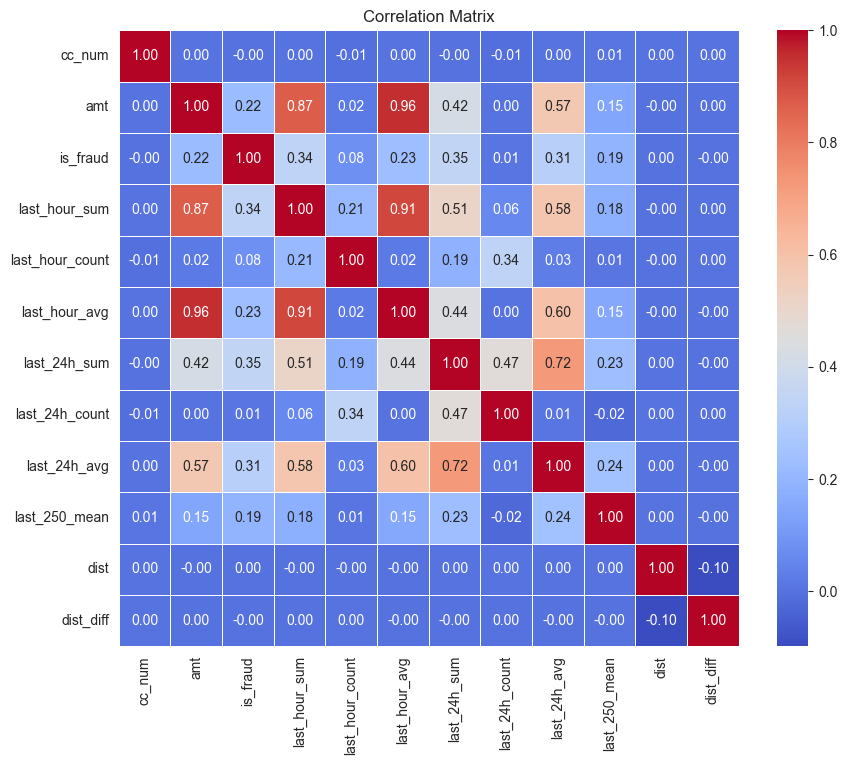

In [14]:
numeric_columns = train.select_dtypes(include=['float64', 'int64', 'int32']).columns
correlation_matrix = train[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   cc_num                 1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   category               1296675 non-null  object        
 3   amt                    1296675 non-null  float64       
 4   unix_time              1296675 non-null  int64         
 5   is_fraud               1296675 non-null  int64         
 6   hour                   1296675 non-null  int32         
 7   transaction_count      1296675 non-null  int64         
 8   avg_amt                1296675 non-null  float64       
 9   Total_amt_d            1296675 non-null  float64       
 10  transaction_count_d    1296675 non-null  int64         
 11  avg_amt_d              1296675 non-null  float64       
 12  dist                   12966

In [9]:
fraud = train[train['is_fraud'] == 1]
non_fraud = train[train['is_fraud'] == 0]

In [10]:
non_fraud.shape

(1289169, 13)

In [10]:
# Get the size of the fraud dataset
fraud_size = fraud.shape[0]

# Calculate the target size for the non-fraud dataset
# reducing it to this size gives a better performance
target_size = fraud_size * 70

# Resample the non-fraud dataset with replacement if needed
resampled_non_fraud = non_fraud.sample(n=target_size, replace=(non_fraud.shape[0] < target_size), random_state=42)

# Combine the fraud and resampled non-fraud datasets if needed
balanced_dataset = pd.concat([fraud, resampled_non_fraud])

# Check the new dataset shape
print("Fraud dataset shape:", fraud.shape)
print("Non-fraud dataset shape after resampling:", resampled_non_fraud.shape)
print("Balanced dataset shape:", balanced_dataset.shape)

Fraud dataset shape: (7506, 12)
Non-fraud dataset shape after resampling: (525420, 12)
Balanced dataset shape: (532926, 12)


In [11]:
def preprocess_data(df):
    # columns_to_drop = ['cc_num', 'trans_date_trans_time', 'amt', 'merchant', 'lat', 'long', 'merch_lat',
    #                     'merch_long', 'trans_num', 'unix_time', 'Year', 'Month', 'Day', 'Week']
    columns_to_drop = ['cc_num', 'trans_date_trans_time', 'amt']
    df = df.drop(columns=columns_to_drop)

    # One-hot encode columns
    part_of_day_onehot = pd.get_dummies(df.part_of_day, prefix='D', drop_first=True)
    category_onehot = pd.get_dummies(df.category, prefix='category', drop_first=True)
    df = pd.concat([df, part_of_day_onehot.astype(int), category_onehot.astype(int)], axis=1)

    return df.drop(columns=['category', 'part_of_day'])

# Preprocess the test and train datasets
test = preprocess_data(test)
# train = preprocess_data(train)
balanced_dataset = preprocess_data(balanced_dataset)
# train.head(2)

In [12]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532926 entries, 115 to 1286284
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   is_fraud                 532926 non-null  int64  
 1   last_hour_count          532926 non-null  float64
 2   last_hour_avg            532926 non-null  float64
 3   last_24h_count           532926 non-null  float64
 4   last_24h_avg             532926 non-null  float64
 5   dist                     532926 non-null  float64
 6   dist_diff                532926 non-null  float64
 7   D_Evening                532926 non-null  int32  
 8   D_Morning                532926 non-null  int32  
 9   D_Night                  532926 non-null  int32  
 10  category_food_dining     532926 non-null  int32  
 11  category_gas_transport   532926 non-null  int32  
 12  category_grocery_net     532926 non-null  int32  
 13  category_grocery_pos     532926 non-null  int32  
 14  catego

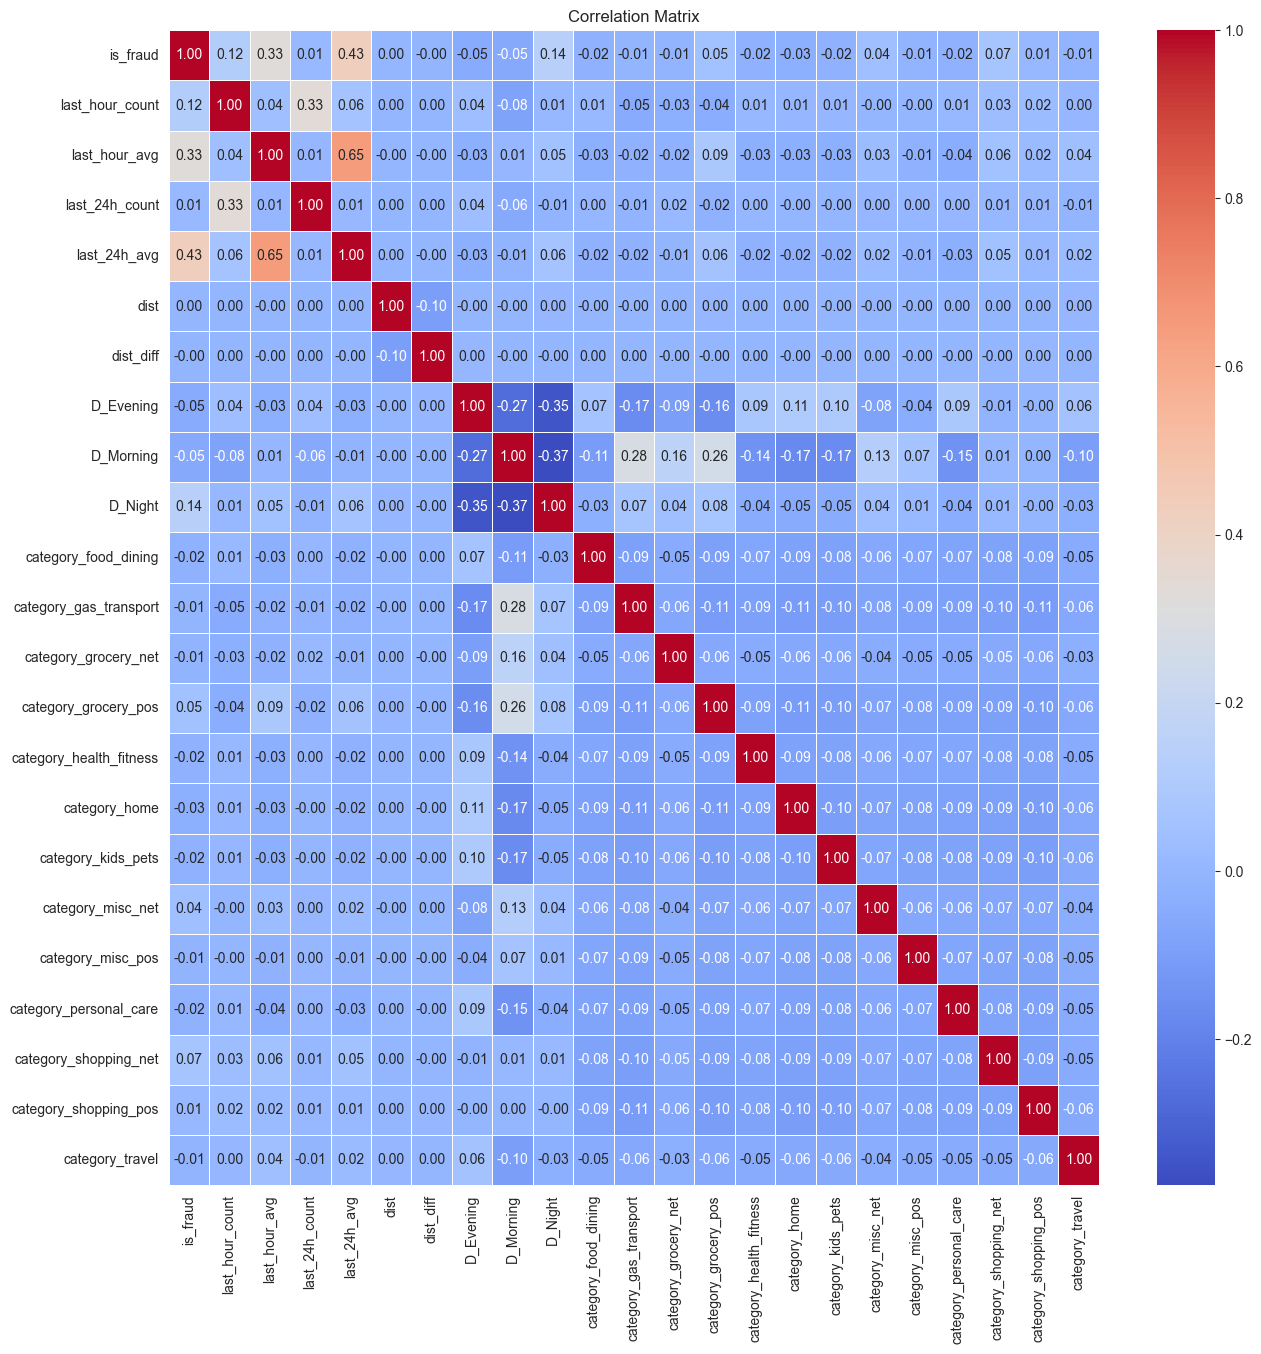

In [11]:
correlation_matrix = balanced_dataset.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X=balanced_dataset.drop(columns=['is_fraud'])
y=balanced_dataset['is_fraud']

# x=train.drop(columns=['is_fraud'])
# y=train['is_fraud']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
# from imblearn.under_sampling import TomekLinks
# # Apply Tomek Links to clean the majority class
# # takes 4-->17 min to work out and reduces the mis-correct classification but on the other hand increases the mis-fraud 
# tomek_links = TomekLinks()
# X_train_tl, y_train_tl = tomek_links.fit_resample(X_train, y_train)

In [14]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix and results
    cm = metrics.confusion_matrix(y_test, y_pred)
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 Score:', f1)
    print('Cohens Kappa Score:', kappa)
    print('Area Under Curve:', auc)
    print('Confusion Matrix:\n', cm)


In [15]:
#Building Random Forest Model
rf_clf = RandomForestClassifier(n_estimators = 50,max_depth = 20,
                                random_state=345, n_jobs=-1, verbose = 1)
rf_clf.fit(X_train, y_train)

print("Train Results")
# Evaluate Model
rf_eval = evaluate_model(rf_clf, X_val, y_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Train Results


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Accuracy: 0.9970852775241121
Precision: 0.9446680080482898
Recall: 0.8406445837063563
F1 Score: 0.8896257697773567
Cohens Kappa Score: 0.8881539890621806
Area Under Curve: 0.9964417563279087
Confusion Matrix:
 [[157534    110]
 [   356   1878]]


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


In [ ]:
import pickle
# Save the model
with open("../artifacts/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_clf, f)

In [15]:
import pickle
# loading the model
with open("../artifacts/random_forest_model.pkl", "rb") as f:
    rf_clf = pickle.load(f)

In [18]:
x_test=test.drop(columns=['is_fraud'])
y_test=test['is_fraud']

In [19]:
lr_real = evaluate_model(rf_clf, x_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Accuracy: 0.998607209758889
Precision: 0.8235016517225107
Recall: 0.8135198135198135
F1 Score: 0.8184803001876173
Cohens Kappa Score: 0.8177812491697453
Area Under Curve: 0.9941189084976545
Confusion Matrix:
 [[553200    374]
 [   400   1745]]


# Anamoly Detection

In [20]:
def eval_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data
    y_pred = model.predict(x_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]

    # Generate confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Generate classification report
    report = metrics.classification_report(y_test, y_pred)
    print("\nClassification Report:\n", report)

    # Calculate ROC-AUC 
    y_prob = model.decision_function(x_test)  # Use decision_function for Isolation Forest
    val_proba = transform_scores(y_prob)
    val_proba = (val_proba > 42.5).astype(int)
    y_prob = (y_prob < 4.0/100).astype(int)
    roc_auc = metrics.roc_auc_score(y_test, y_prob)
    roc_auc_transfrom = metrics.roc_auc_score(y_test, val_proba)
    print("\nROC-AUC Score:", roc_auc)
    print("ROC-AUC Score (transformed):", roc_auc_transfrom)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import IsolationForest
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',  # Let the algorithm estimate the fraud rate
    max_features=1.0,
    bootstrap=False,
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit the model
iso_forest.fit(X_train)

# Calculate anomaly scores (-1 to 1 where -1 is most anomalous)
train_scores = iso_forest.decision_function(X_train)
val_scores = iso_forest.decision_function(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


In [125]:
# Transform scores to make fraud cases have higher values
def transform_scores(scores, max_score, min_score):
    """
    Convert Isolation Forest scores to fraud scores where:
    - Higher values indicate higher probability of fraud
    - Scores range from 0 (normal) to 100 (definite fraud)
    """
    # Shift scores so anomalies are positive
    shifted = -scores  # Invert the scores
    
    # Normalize to 0-100 range
    normalized = 100 * (shifted - min_score) / (max_score - min_score)
    normalized = np.clip(normalized, 0, 100)
    
    return normalized

max_score = np.max(train_scores)
min_score = np.min(train_scores)

train_proba = transform_scores(train_scores, max_score, min_score)
val_proba = transform_scores(val_scores, max_score, min_score)

# Create DataFrames with the results
train_results = pd.DataFrame({
    'actual': y_train,
    'score': train_scores,
    'fraud_probability': train_proba
})

val_results = pd.DataFrame({
    'actual': y_val,
    'score': val_scores,
    'fraud_probability': val_proba
})

<Axes: xlabel='fraud_probability', ylabel='Density'>

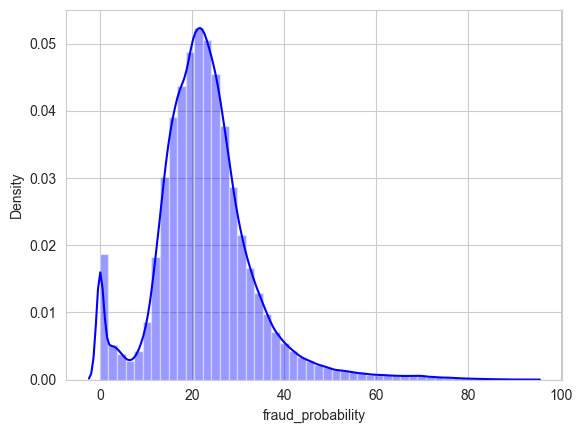

In [128]:
sns.distplot(train_results['fraud_probability'], kde=True, color='blue', label='Train Fraud Probability')

In [35]:
# Convert probabilities to binary predictions using a threshold
threshold = 59.7980  # Adjust based on your business needs
val_results['predicted'] = (val_results['fraud_probability'] > threshold).astype(int)
val_results["score_pred"] = (val_results["score"] < 4.0/100).astype(int)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(val_results['actual'], val_results['predicted']))
print(confusion_matrix(val_results['actual'], val_results['score_pred']))

print("\nClassification Report:")
print(classification_report(val_results['actual'], val_results['predicted']))
print(classification_report(val_results['actual'], val_results['score_pred']))

print("\nROC AUC Score:", roc_auc_score(val_results['actual'], val_results['fraud_probability']))
print("\nROC AUC Score:", roc_auc_score(val_results['actual'], val_results['score_pred']))

Confusion Matrix:
[[104357    728]
 [   730    771]]
[[94203 10882]
 [  221  1280]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    105085
           1       0.51      0.51      0.51      1501

    accuracy                           0.99    106586
   macro avg       0.75      0.75      0.75    106586
weighted avg       0.99      0.99      0.99    106586

              precision    recall  f1-score   support

           0       1.00      0.90      0.94    105085
           1       0.11      0.85      0.19      1501

    accuracy                           0.90    106586
   macro avg       0.55      0.87      0.57    106586
weighted avg       0.99      0.90      0.93    106586


ROC AUC Score: 0.9338343247211729

ROC AUC Score: 0.874605278928257


In [26]:
# To find optimal threshold (example)
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    val_results['actual'], 
    val_results['fraud_probability']
)

# Find threshold that gives best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold:.4f}")

Optimal threshold: 59.7980


In [ ]:
import joblib

# Save the trained Isolation Forest model to a file
joblib.dump(iso_forest, "../artifacts/iso_forest_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [13]:
# Load the saved model
iso_forest_loaded = joblib.load("../artifacts/iso_forest_model.pkl")
print("Model loaded successfully!")

Model loaded successfully!


In [29]:
# Predict the outliers on the on a real set
y_pred_test = iso_forest.predict(x_test)
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]

print("\nTest Results:")
eval_model(iso_forest, x_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s



Test Results:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s


Confusion Matrix:
 [[541022  12552]
 [   729   1416]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.10      0.66      0.18      2145

    accuracy                           0.98    555719
   macro avg       0.55      0.82      0.58    555719
weighted avg       1.00      0.98      0.98    555719



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s



ROC-AUC Score: 0.8571423779511586
ROC-AUC Score (transformed): 0.8614557664417304


# End

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor

# # Initialize Local Outlier Factor model
# lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)

# # Fit the model
# lof.fit(X_train)

# # Predict the outliers on the training set
# y_pred_train = lof.predict(X_train)

# # Predict the outliers on the test set
# y_pred_test = lof.predict(X_val)


# # Evaluate the model
# print("Train Results")
# lof_eval = eval_model(lof, X_val, y_test)

# # Print results
# print(f'Accuracy: {lof_eval["acc"]}')
# print(f'Precision: {lof_eval["prec"]}')
# print(f'Recall: {lof_eval["rec"]}')
# print(f'F1 Score: {lof_eval["f1"]}')
# print(f'Cohen\'s Kappa Score: {lof_eval["kappa"]}')
# print(f'Confusion Matrix:\n {lof_eval["cm"]}')


# y_pred_test = lof.predict(X_val)
# y_pred_test


# lr_real = eval_model(lof, x_test, y_test)

# # Print result
# print('Accuracy:', lr_real['acc'])
# print('Precision:', lr_real['prec'])
# print('Recall:', lr_real['rec'])
# print('F1 Score:', lr_real['f1'])
# print('Cohens Kappa Score:', lr_real['kappa'])
# print('Area Under Curve:', lr_real['auc'])
# print('Confusion Matrix:\n', lr_real['cm'])

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.barplot(x='category', y='amt', hue='is_fraud', data=train_df, estimator='mean')
# plt.xticks(rotation=90)
# plt.title('Average Transaction Amount by Category: Fraud vs Non-Fraud')
# plt.xlabel('Category')
# plt.ylabel('Average Transaction Amount')
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='long', y='lat', hue='is_fraud', data=train_df, alpha=0.5)
# plt.title('Geographical Distribution of Fraud vs Non-Fraud Transactions')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()